# **Multiclass Logistic Regression**

In this tutorial, we will solve a *classification* problem with multiclass logistic regression.  As usual, we are going to use gradient descend.

## Dataset
We have a training set composed of 2-dimensional inputs:
$\mathbf{x}_i = [x_1, x_2]^T$, where $\mathbf{x}_i \in \mathbb{R}^2$.
For convenience, we gather all the inputs into a matrix $\mathbf{X}$:


$\mathbf{X} = \begin{bmatrix}
1 & x_{1,1} & x_{1,2}\\
1 & x_{2,1} & x_{2,2}\\
1 & ...  & ...\\
1 & x_{N,1} & x_{N,2}\\
\end{bmatrix}$

where $\mathbf{X} \in \mathbb{R}^{N \times 3}$.

For each input, we have a label $y_i$ that can be 0, 1, or 2:

As for the labels, it is convenient to gather them into a matrix:

$\mathbf{Y} = \begin{bmatrix}
0 & 0 & 1 &\\
0 & 1 & 0 &\\
... & ... & ... &\\
0 & 0 & 1 &\\
1 & 0 & 0 &
\end{bmatrix}$

where $\mathbf{Y} \in \mathbb{R}^{N\times 3}$. This representation is called *one-hot* and encodes the labels in this way:
we put one to the column index corresponding to the correct class and zeroes everywhere else.  For instance, the first element will be class 2 (because we have 1 in index 2), the second one will be class 1, etc.


## Model
The multiclass logistic regression estimates the probability of our k class given the input $\mathbf{x}_i$ and a weight matrix $\mathbf{W}$ in this way:

$p(y_i = k \mid \mathbf{x}_i, \mathbf{W}) = softmax(\mathbf{W}^T\mathbf{x}_i)_k$.

The weight matrix $\mathbf{W}$ has dimensionality $3 \times 3$ (i.e., feature dimensionalitiy $\times$ number of classes):

$\mathbf{W} = [\mathbf{w}_0, \mathbf{w}_1, \mathbf{w}_2] = \begin{bmatrix}
w_{0,0} & w_{1,1} & w_{1,2}\\
w_{1,1} & w_{2,2} & w_{2,2}\\
w_{2,1} & w_{2,2} & w_{2,2}\\
\end{bmatrix}$.


The softmax function, instead, is defined as:

$softmax(\mathbf{W}^T\mathbf{x}_i)_k = \frac{\exp(\mathbf{w}^T_k \mathbf{x})}{\sum_{i=j}^K \exp(\mathbf{w}^T_j \mathbf{x})}$


## Objective
Our goal is to find a configuration of our parameters $\mathbf{W}$ that minimizes our objective function.
For multiclass logistic regression, we use the **categorical cross-entropy** loss (also known as **negative log-likelihood**):

$NLL(\mathbf{W}) = -\ln P(\mathbf{Y} \mid \mathbf{X}, \mathbf{w}) = -\sum_{i=1}^N \sum_{k=1}^K y_{ik} \ln softmax(\mathbf{W}^T\mathbf{x}_i)_k$


The categorical cross-entropy is low when the output probabilities are close to their corresponding labels.

# Data Generation

Let's use the following function to generate our data for the three classes. As usual, remember that the data generation process is something not accessible directly in a real machine learning problem (e.g., think about the hidden process that generates complex data like images or speech signals).

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

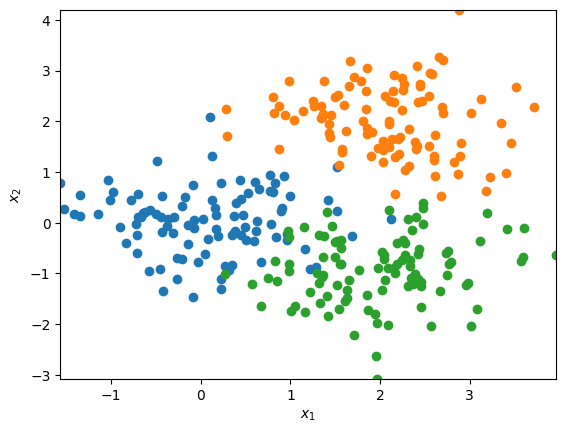

In [ ]:
def get_dataset(N=100,
                mu0 = np.array([0,0]),
                cov0 = np.array([[0.45,0],[0,0.45]]),
                mu1 = np.array([2,2]),
                cov1 = np.array([[0.45,0],[0,0.45]]),
                mu2 = np.array([2,-1]),
                cov2 = np.array([[0.45,0],[0,0.45]])
                ):
  """Creates data for classification by drawing samples from 3 gaussians.
  It returns the inputs and the corresponding labels in one-hot format.
  """

  # Class 0 samples
  X0 = np.random.multivariate_normal(mu0, cov0, N)

  # One-hot representation
  Y0 = np.zeros((X0.shape[0],3))
  Y0[:,0] = 1

  # Class 1 samples
  X1 = np.random.multivariate_normal(mu1, cov1, N)

  # One-hot representation
  Y1 = np.zeros((X1.shape[0],3))
  Y1[:,1] = 1

  # Class 3 samples
  X2 = np.random.multivariate_normal(mu2, cov2, N)

  # One-hot representation
  Y2 = np.zeros((X1.shape[0],3))
  Y2[:,2] = 1

  X = np.concatenate([X0,X1,X2])
  # Adding the ones is needed to vectorize everything (see lecture)
  X = np.concatenate([np.ones([X.shape[0],1]), X], axis=1)
  Y = np.concatenate([Y0,Y1,Y2])
  return X,Y

def plot_data(X_train, y_train):
  """Scatterplot of the data with their labels"""
  plt.scatter(X_train[np.where(y_train[:,0]==1),1], X_train[np.where(y_train[:,0]==1),2])
  plt.scatter(X_train[np.where(y_train[:,1]==1),1], X_train[np.where(y_train[:,1]==1),2])
  plt.scatter(X_train[np.where(y_train[:,2]==1),1], X_train[np.where(y_train[:,2]==1),2])

  plt.xlim(X_train[:,1].min(), X_train[:,1].max())
  plt.ylim(X_train[:,2].min(), X_train[:,2].max())
  plt.ylabel(r'$x_2$')
  plt.xlabel(r'$x_1$')
  plt.show()


# Sample data for test and training
X_train, Y_train = get_dataset()
X_test, Y_test = get_dataset()

# Plot training data
plot_data(X_train,Y_train)

Let's define some support functions that we will use during training:

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x) # subtracting max for numerical stability
    return e_x / e_x.sum(axis=1, keepdims=True)

def multiclass_logistic_regression(X, W):
  "Multiclass Logistic regression. We here use the vectorized form to\
  improve parallelization and make everything more efficient."
  return softmax(np.dot(X,W))

def NLL(y_hat,y):
    "Computes the categorical cross-entropy given the predictions and\
    the labels."
    nll = y * np.log(y_hat)
    return -nll.mean()

def plot_boundaries(X, W, Y, h = 0.02):
    """Plots the data with the decision boundaries"""

    # create a mesh to plot in
    x1min = X[:,1].min()
    x1max = X[:,1].max()
    x2min = X[:,2].min()
    x2max = X[:,2].max()

    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, h), np.arange(x2min, x2max, h))
    X_grid = np.vstack([xx1.ravel(),xx2.ravel()]).T

    # Adding the ones is needed to vectorize everything (see lecture)
    X_grid = np.concatenate([np.ones([X_grid.shape[0],1]), X_grid], axis=1)

    Y_hat_grid = multiclass_logistic_regression(X_grid, W)
    y_pred_grid = np.argmax(Y_hat_grid, axis=1)
    y_pred_grid = y_pred_grid.reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, y_pred_grid, cmap=plt.cm.Paired)

    plot_data(X,Y)
    plt.show()

# **Multiclass Logistic Regression with NumPy**
All right, we can now implement gradient descend. To use it, we need to compute the gradient of the objective function over the learnable parameters. As we have seen in the lectures, this gradient is given by:

$\mathbf{J}_{NLL}(\mathbf{W}) = \mathbf{X}^T \big(softmax(\mathbf{X}\mathbf{W}) -\mathbf{Y}\big)$

We are going to use here the fully vectorized version of the gradient equation to avoid *for loops* when implementing our model. For loops can be slow, while matrix multiplications can be easily parallelized.

The following function is going to implement a basic version of gradient descend:
- We initialize the parameters $\mathbf{w}$ with random numbers
- We initialize the hyperparameters (learning rate and number of epochs)
- We compute the gradient, update the parameters, and loop for the specified number of epochs.

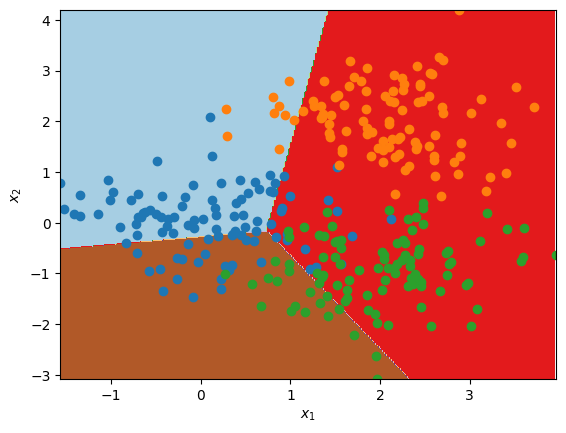

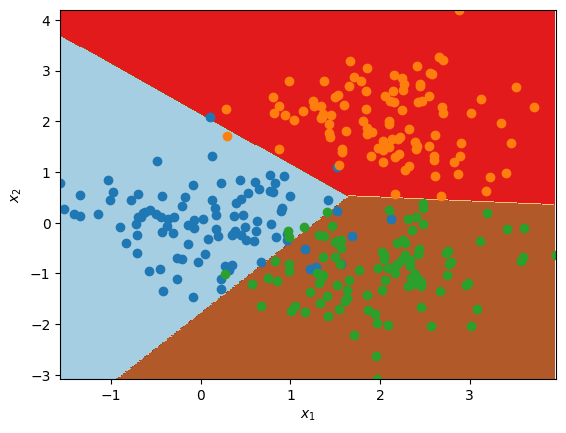

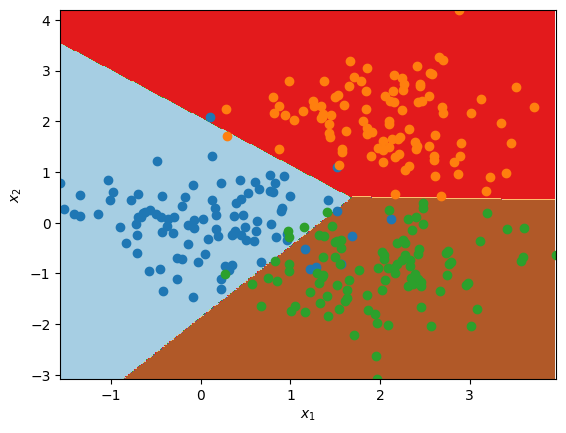

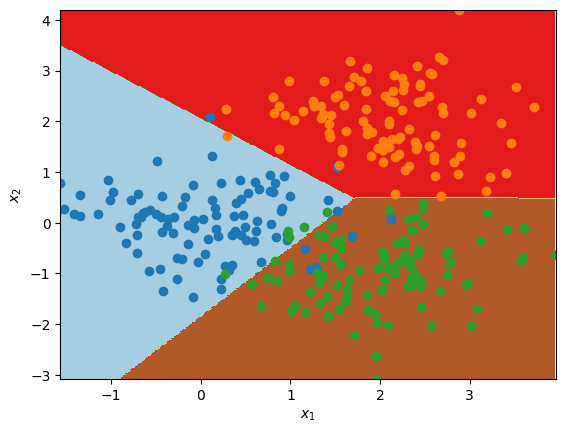

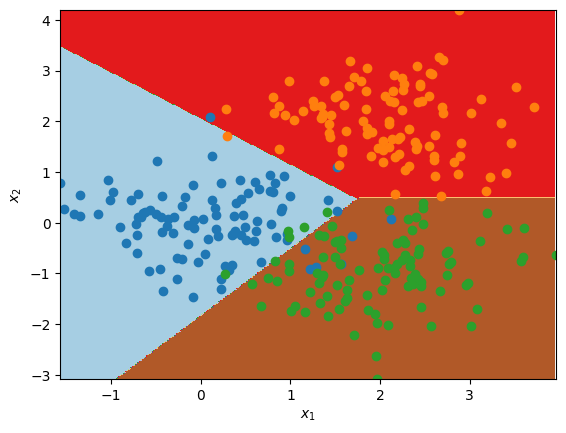

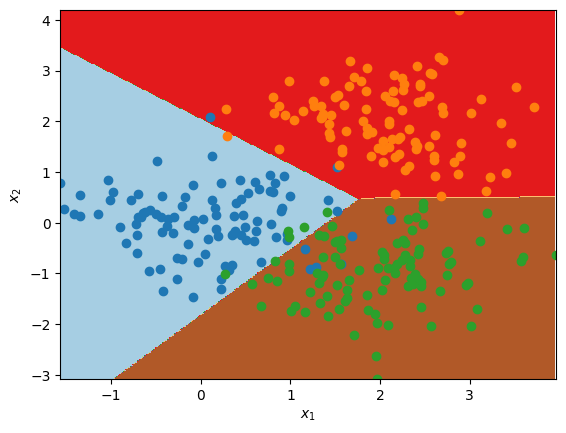

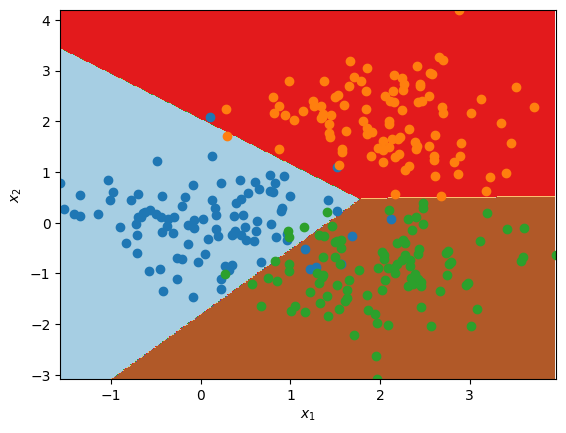

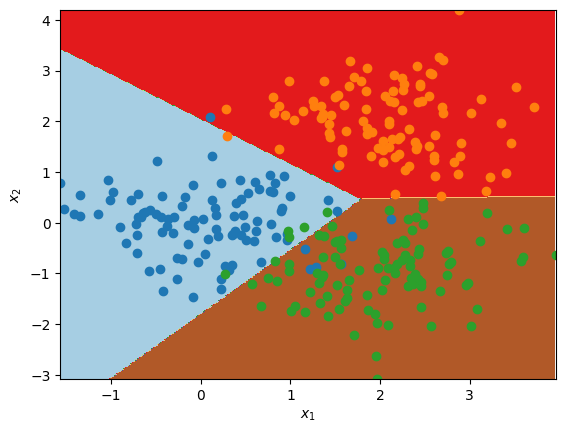

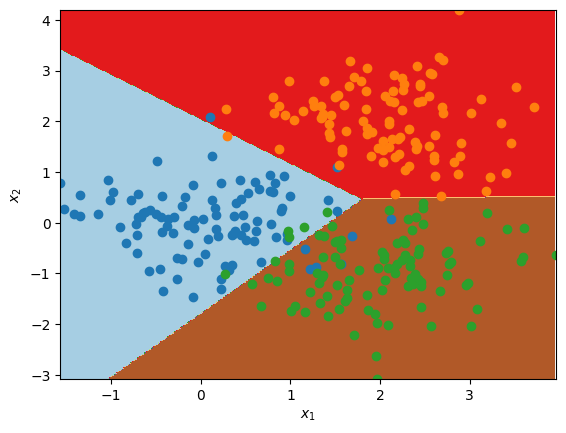

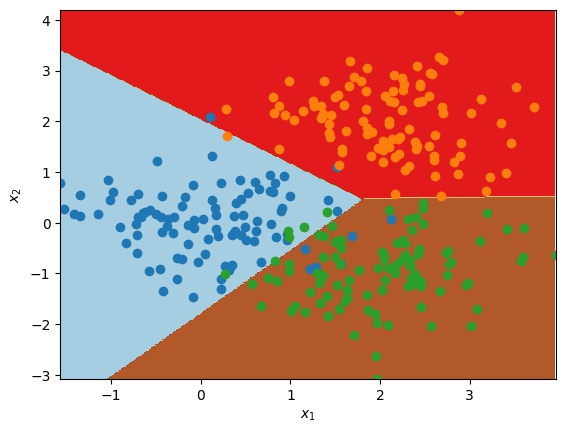

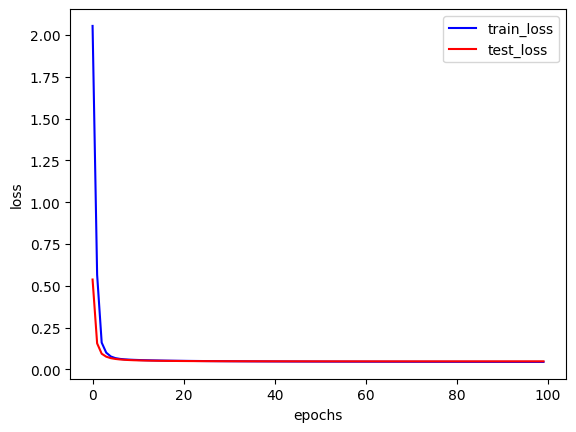

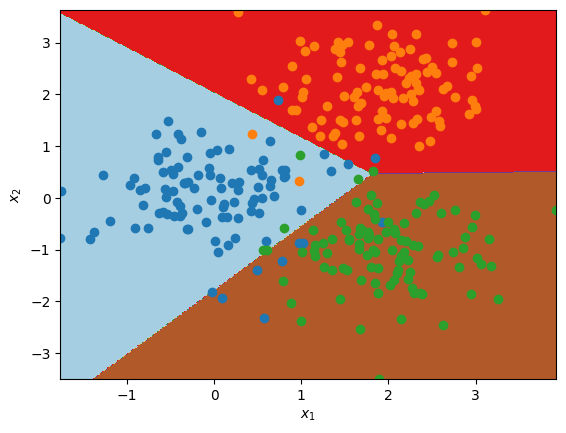

In [ ]:
# Initial Values
W = np.array([[1.5, 0.0, 0.5], [-0.5, 6.5, -2.0], [1.0, -1.0, -1.3]])
N_epochs = 100
lr = 0.01
plot_every=10

train_losses = []
test_losses = []

for epoch in range(N_epochs):

  # compute the predictions
  Y_hat = multiclass_logistic_regression(X_train, W)

  # compute the gradient
  grad = np.dot(X_train.T,(Y_hat - Y_train))

  # parameter updates with gradient descend
  W = W - lr * grad

  # Loss computation (just to monitor)
  tr_loss = NLL(Y_hat,Y_train)
  Y_hat_test = multiclass_logistic_regression(X_test, W)
  te_loss = NLL(Y_hat_test,Y_test)

  # Store the training and test losses (just to monitor)
  train_losses.append(tr_loss)
  test_losses.append(te_loss)

  # Plot the data and the classification with the decision boundary.
  if epoch % plot_every == 0:
    plot_boundaries(X_train, W, Y_train)



# Plot the training curve
plt.plot(train_losses, color='blue')
plt.plot(test_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])
plt.show()

# Plot the test data
plot_boundaries(X_test, W, Y_test)



The algorithm starts from a bad solution. Thanks to gradient descent, however, we quickly improve it. In the end, the solution classifies pretty well the test data as well.



# **Multiclass Logistic Regression with scikit-learn**

The scikit learn library has a build-in function for logistic regression. The function supports both binary and multiclass classification (using `multi_class='multinomial'`). We can use it in this way:

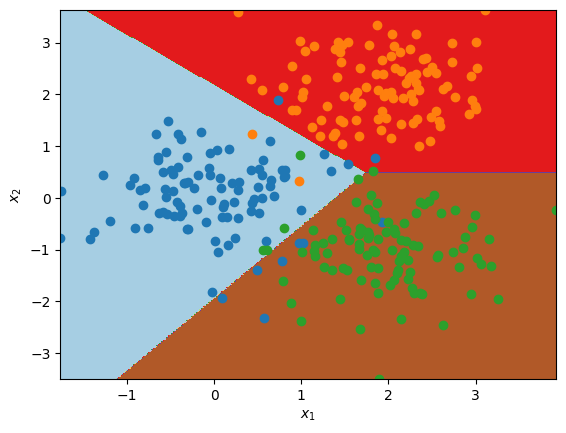

(3, 3)


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='multinomial').fit(X_train[:,1:], Y_train.argmax(axis=1))
W = np.concatenate([np.expand_dims(clf.intercept_,1), clf.coef_], axis=1).T

# Plot the test data
plot_boundaries(X_test, W, Y_test)

print(W.shape)

As you can see the solution found with our implementation is very similar to that obtained by scikit learn. Note, however, that by default scikit learn applies L2 regularization.